<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Numerical Solution of the Scalar Wave Equation, in Cartesian Coordinates

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## This module solves the scalar wave equation for a plane wave in Cartesian coordinates, using the [Method of Lines](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).

**Notebook Status:** <font color='green'><b>Validated</b></font>

**Validation Notes:** This module has been validated to converge at the expected order to the exact solution (see [plot](#convergence) at bottom).

### NRPy+ Source Code for this module: 
* [ScalarWave/ScalarWave_RHSs.py](../edit/ScalarWave/ScalarWave_RHSs.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) Generates the right-hand side for the Scalar Wave Equation in cartesian coordinates
* [ScalarWave/InitialData_PlaneWave.py](../edit/ScalarWave/InitialData_PlaneWave.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) Generating C code for plane wave initial data for the scalar wave equation

## Introduction:

As outlined in the [previous NRPy+ tutorial notebook](Tutorial-ScalarWave.ipynb), we first use NRPy+ to generate initial data for the scalar wave equation, and then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step:

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration
    * [**NRPy+ tutorial notebook on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).
1. Set gridfunction values to initial data 
    * [**NRPy+ tutorial notebook section on plane-wave solution to scalar wave equation**](Tutorial-ScalarWave.ipynb#planewavesoln)
1. Next, integrate the initial data forward in time using the Method of Lines coupled to a Runge-Kutta explicit timestepping algorithm:
    1. At the start of each iteration in time, output the difference between the numerical and exact solution
        * [**NRPy+ tutorial notebook section on plane-wave solution to scalar wave equation**](Tutorial-ScalarWave.ipynb#planewavesoln).
    1. At each RK time substep, do the following:
        1. Evaluate scalar wave RHS expressions 
            * [**NRPy+ tutorial notebook section on right-hand sides of scalar wave equation, in 3 spatial dimensions**](Tutorial-ScalarWave.ipynb#rhss3d)
        1. Apply boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#setup): Set up core functions and parameters for solving scalar wave equation
    1. [Step 1.a](#applybcs) `apply_bcs()`: outer boundary condition driver function
    1. [Step 1.b](#mol) Generate Runge-Kutta-based Method of Lines timestepping code
    1. [Step 1.c](#freeparams) Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h`
1. [Step 2](#mainc): `ScalarWave_Playground.c`: The Main C Code
1. [Step 3](#convergence): Code validation: Verify that relative error in numerical solution converges to zero at the expected order
1. [Step 4](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='setup'></a>

# Step 1: Set up core functions and parameters for solving scalar wave equation \[Back to [top](#toc)\]
$$\label{setup}$$

Let's pick up where we left off in the [previous module](Tutorial-ScalarWave.ipynb), interfacing with the [ScalarWave/InitialData_PlaneWave](../edit/ScalarWave/InitialData_PlaneWave.py) and [ScalarWave/ScalarWave_RHSs](../edit/ScalarWave/ScalarWave_RHSs.py) NRPy+ modules to generate
* monochromatic (single-wavelength) plane wave scalar wave initial data, and
* the scalar wave equation RHSs at **4th** finite difference order in **3 spatial dimensions**

In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import *            # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions

# Step P2: Create C code output directory:
Ccodesdir = os.path.join("ScalarWave_Ccodes/")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
# !rm -r ScalarWaveCurvilinear_Playground_Ccodes
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesdir,"output/")
cmd.mkdir(outdir)

# Step P4: Set domain_size, the physical extent of numerical grid;
#          in Cartesian coordinates xmin=ymin=zmin=-domain_size, 
#          and xmax=ymax=zmax=+domain_size
domain_size = 10.0

# Step P5: Set timestepping algorithm (we adopt the Method of Lines)
RK_method = "RK4"

# Step P6: Set the finite differencing order to 4.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",4)

# Step 1: Import the ScalarWave.InitialData module. 
#         This command only declares ScalarWave initial data 
#         parameters and the InitialData_PlaneWave() function.
import ScalarWave.InitialData_PlaneWave as swid

# Step 2: Import ScalarWave_RHSs module. 
#         This command only declares ScalarWave RHS parameters
#         and the ScalarWave_RHSs function (called later)
import ScalarWave.ScalarWave_RHSs as swrhs

# Step 3: Set the spatial dimension parameter
#         to 3, and then read the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 4: Call the InitialData_PlaneWave() function to set up
#         monochromatic (single frequency/wavelength) scalar
#         wave initial data.
swid.InitialData_PlaneWave()

# Step 5: Generate SymPy symbolic expressions for
#         uu_rhs and vv_rhs; the ScalarWave RHSs.
#         This function also declares the uu and vv
#         gridfunctions, which need to be declared
#         to output even the initial data to C file.
swrhs.ScalarWave_RHSs()

# Step 6: Generate all needed C functions
desc="Part P3: Declare the function for the exact solution at a single point. time==0 corresponds to the initial data."
name="exact_solution_single_point"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="const REAL xx0,const REAL xx1,const REAL xx2,const paramstruct *restrict params,REAL *uu_exact,REAL *vv_exact",
    body     = fin.FD_outputC("returnstring",[lhrh(lhs="*uu_exact",rhs=swid.uu_ID),
                                              lhrh(lhs="*vv_exact",rhs=swid.vv_ID)]),
    loopopts = "")


desc="Part P4: Declare the function for the exact solution at all points. time==0 corresponds to the initial data."
name="exact_solution_all_points"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict in_gfs",
    body     ="exact_solution_single_point(xx0,xx1,xx2,params,&in_gfs[IDX4S(UUGF,i0,i1,i2)],&in_gfs[IDX4S(VVGF,i0,i1,i2)]);",
    loopopts = "AllPoints,Read_xxs")


desc="Part P5: Declare the function to evaluate the scalar wave RHSs"
name="rhs_eval"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="const paramstruct *restrict params, const REAL *restrict in_gfs, REAL *restrict rhs_gfs",
    body     =fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("rhs_gfs","uu"),rhs=swrhs.uu_rhs),
                                             lhrh(lhs=gri.gfaccess("rhs_gfs","vv"),rhs=swrhs.vv_rhs)],
                             params="SIMD_enable=True").replace("IDX4","IDX4S"),
    loopopts = "InteriorPoints,EnableSIMD")

Output C function exact_solution_single_point() to file ScalarWave_Ccodes/exact_solution_single_point.h
Output C function exact_solution_all_points() to file ScalarWave_Ccodes/exact_solution_all_points.h
Output C function rhs_eval() to file ScalarWave_Ccodes/rhs_eval.h


<a id='applybcs'></a>

## Step 1.a: `apply_bcs()`: outer boundary condition driver function
$$\label{applybcs}$$

When solving the wave equation on a 3D Cartesian numerical grid cube (or, if you like, rectangular prism), at each step in time, we first evaluate the right-hand sides (RHSs) of the $\partial_t u$ and $\partial_t v$ equations. 

These RHSs generally contain spatial derivatives, which we evaluate using finite-difference differentiation ([**tutorial**](Tutorial-Finite_Difference_Derivatives.ipynb)). Each finite-difference derivative depends on neighboring points on the left and right, so the RHSs can only be evaluated in the grid interior. For example, a standard fourth-order centered finite difference derivative depends on two points to the left and right of the point at which the derivative is being evaluated. In order for the same interior to be filled at the next time step, we need to fill in the data at the boundaries; i.e., we need to apply boundary conditions.

Here we quadratically extrapolate data to the outer boundary using the `FACE_UPDATE()` C macro defined below. The C code function `apply_bcs()` below updates all 6 faces of the cube. To ensure that all gridpoints on the outer boundary (also known as "ghost cells") are filled, the following algorithm is implemented, starting at the innermost ghost cells (i.e., the ghost cells closest to the grid interior):

1. The lower $x$ face is updated on only the interior points of the face.
1. The upper $x$ face is updated on only the interior points of the face.
1. The lower $y$ face is updated on the interior points of that face, plus the lower and upper $x$ boundary points
1. The upper $y$ face is updated on the interior points of that face, plus the lower and upper $x$ boundary points
1. The lower $z$ face is updated on the interior points of that face, plus the lower and upper $x$ boundary points, plus the lower and upper $y$ boundary points
1. The upper $z$ face is updated on the interior points of that face, plus the lower and upper $x$ boundary points, plus the lower and upper $y$ boundary points
1. The above is repeated on the next outer ghost cell, until all outer boundary points are filled.

In [2]:
%%writefile $Ccodesdir/apply_bcs.h

// Declare boundary condition FACE_UPDATE macro,
//          which updates a single face of the 3D grid cube
//          using quadratic polynomial extrapolation.
const int MAXFACE = -1;
const int NUL     = +0;
const int MINFACE = +1;
#define  FACE_UPDATE(which_gf, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) { \
        gfs[IDX4S(which_gf,i0,i1,i2)] =                                  \
          +3.0*gfs[IDX4S(which_gf,i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]  \
          -3.0*gfs[IDX4S(which_gf,i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]  \
          +1.0*gfs[IDX4S(which_gf,i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)]; \
      }
    
void apply_bcs(const paramstruct *restrict params,REAL *restrict gfs) {
#pragma omp parallel for
    for(int which_gf=0;which_gf<NUM_EVOL_GFS;which_gf++) {
#include "set_Cparameters.h"
        int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
        int imax[3] = { Nxx_plus_2NGHOSTS0-NGHOSTS, Nxx_plus_2NGHOSTS1-NGHOSTS, Nxx_plus_2NGHOSTS2-NGHOSTS };
        for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
            // After updating each face, adjust imin[] and imax[] 
            //   to reflect the newly-updated face extents.
            FACE_UPDATE(which_gf, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]--;
            FACE_UPDATE(which_gf, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]++;

            FACE_UPDATE(which_gf, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]--;
            FACE_UPDATE(which_gf, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]++;

            FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]--;
            FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]++;
        }
    }
}

Writing ScalarWave_Ccodes//apply_bcs.h


<a id='mol'></a>

## Step 1.b: Generate Runge-Kutta-based Method of Lines timestepping code \[Back to [top](#toc)\]
$$\label{mol}$$

The Method of Lines algorithm is described in detail in the [**NRPy+ tutorial notebook on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).

In [3]:
# Step 1.b: Generate Runge-Kutta-based (RK-based) timestepping code. 
#       As described above the Table of Contents, this is a 2-step process:
#       1.b.A: Evaluate RHSs (RHS_string)
#       1.b.B: Apply boundary conditions (post_RHS_string, pt 1)
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))
MoL.MoL_C_Code_Generation(RK_method, 
    RHS_string      = "rhs_eval(&params,   RK_INPUT_GFS, RK_OUTPUT_GFS);",
    post_RHS_string = "apply_bcs(&params,  RK_OUTPUT_GFS);",
    outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))

<a id='freeparams'></a>

## Step 1.c: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{freeparams}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [4]:
# Step 3.d.i: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

domain_size_str=str(domain_size)
# Step 3.d.ii: Set free_parameters.h
with open(os.path.join(Ccodesdir,"free_parameters.h"),"w") as file:
    file.write("""
// Set free-parameter values.

// Set free-parameter values for the initial data.
params.time = 0.0; params.wavespeed = 1.0;
params.kk0 = 1.0; params.kk1 = 1.0; params.kk2 = 1.0;

const REAL domain_size    = """+str(domain_size)+""";

// Override parameter defaults with values based on command line arguments and NGHOSTS.
const int Nx0x1x2 = atoi(argv[1]);
params.Nxx0 = Nx0x1x2;
params.Nxx1 = Nx0x1x2;
params.Nxx2 = Nx0x1x2;
params.Nxx_plus_2NGHOSTS0 = params.Nxx0 + 2*NGHOSTS;
params.Nxx_plus_2NGHOSTS1 = params.Nxx1 + 2*NGHOSTS;
params.Nxx_plus_2NGHOSTS2 = params.Nxx2 + 2*NGHOSTS;
// Step 0d: Set up space and time coordinates
// Step 0d.i: Declare \Delta x^i=dxx{0,1,2} and invdxx{0,1,2}, as well as xxmin[3] and xxmax[3]:
const REAL xxmin[3] = {-"""+domain_size_str+""",-"""+domain_size_str+""",-"""+domain_size_str+""" };
const REAL xxmax[3] = {+"""+domain_size_str+""",+"""+domain_size_str+""",+"""+domain_size_str+""" };

params.dxx0 = (xxmax[0] - xxmin[0]) / ((REAL)params.Nxx0);
params.dxx1 = (xxmax[1] - xxmin[1]) / ((REAL)params.Nxx1);
params.dxx2 = (xxmax[2] - xxmin[2]) / ((REAL)params.Nxx2);
params.invdx0 = 1.0 / params.dxx0;
params.invdx1 = 1.0 / params.dxx1;
params.invdx2 = 1.0 / params.dxx2;
\n""")

# Generates declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

<a id='mainc'></a>

# Step 2: `ScalarWave_Playground.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$

Next we will write the C code infrastructure necessary to make use of the above NRPy+-generated codes. Again, we'll be using RK4 time integration via the Method of Lines.

In [5]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open(os.path.join(Ccodesdir,"ScalarWave_NGHOSTS.h"), "w") as file:
    file.write("// Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2))+"\n")

In [6]:
%%writefile $Ccodesdir/ScalarWave_Playground.c

// Part P0: Import NGHOSTS, which is based on FD_CENTDERIVS_ORDER
#include "ScalarWave_NGHOSTS.h"
// Part P0a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

#include "declare_Cparameters_struct.h"

// All SIMD intrinsics used in SIMD-enabled C code loops are defined here:
#include "../SIMD/SIMD_intrinsics.h"

const int NSKIP_0D_OUTPUT = 1;
const int NSKIP_2D_OUTPUT = 10;

// Part P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"

// Part P2: Add needed #define's to set data type, the IDX4S() macro, and the gridfunctions
// Part P2a: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)
// Part P2b: Set UUGF and VVGF macros
#define NUM_EVOL_GFS 2
#define UUGF 0
#define VVGF 1

// Part P3: Declare the function for the exact solution at a single point. time==0 corresponds to the initial data.
#include "exact_solution_single_point.h"

// Part P4: Declare the function for the exact solution at all points. time==0 corresponds to the initial data.
#include "exact_solution_all_points.h"

// Part P5: Declare the function to evaluate the scalar wave RHSs
#include "rhs_eval.h"

// Part P6: Boundary condition driver routine: Apply BCs to all six
//          boundary faces of the cube, filling in the innermost
//          ghost zone first, and moving outward.
#include "apply_bcs.h"

// Part P7: 2D File output routine, for comparing numerical results to exact solution
void output_2D(const paramstruct *restrict params, const int iter, REAL *xx[3],
               const REAL *numerical_gridfunction_data,REAL *gridfunction_to_store_exact) {
#include "set_Cparameters.h"
    // Step 2a: Validation: Output to 2D data files numerical and exact solutions
    char filename[100];
    sprintf(filename,"out2D__resolution_%dx%dx%d__iter_%d.txt",Nxx0,Nxx1,Nxx2,iter);
    FILE *out2D = fopen(filename, "w");
    const int i2  = (int)((Nxx2+ 2*NGHOSTS)*0.5);
    const REAL xx2 = xx[2][i2];
    for(int i0=0;i0<Nxx0+2*NGHOSTS;i0++) {
        for(int i1=0;i1<Nxx1+2*NGHOSTS;i1++) {
            if(i0> (Nxx0+2*NGHOSTS)*.25 && i0< (Nxx0+2*NGHOSTS)*.75 &&
               i1> (Nxx1+2*NGHOSTS)*.25 && i1< (Nxx1+2*NGHOSTS)*.75) { 
                const REAL xx0 = xx[0][i0];
                const REAL xx1 = xx[1][i1];
                REAL uu_exact,vv_exact; exact_solution_single_point(xx0,xx1,xx2,params, &uu_exact,&vv_exact);
                fprintf(out2D,"%e %e %e %e\n", xx0,xx1,
                        numerical_gridfunction_data[IDX4S(0,i0,i1, (int)((Nxx2+ 2*NGHOSTS)*0.5))], uu_exact);
            }
        }
    }
    fclose(out2D);
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"
    // Step 0a: Read command-line input, error out if nonconformant
    if(argc != 2 || atoi(argv[1]) < NGHOSTS) {
      printf("Error: Expected one command-line argument: ./ScalarWave_Playground [Nx(=Ny=Nz)],\n");
      printf("where Nx is the number of grid points in the x,y, and z directions.\n");
      printf("Nx MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
      exit(1);
    }
    // Step 0c: Set free parameters, overwriting Cparameters defaults 
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"
#include "set_Cparameters-nopointer.h"

    //          ... and then set up the numerical grid structure in time:
    const REAL t_final = xxmax[0]*0.8; /* Final time is set so that at t=t_final, 
                                        data at the origin have not been corrupted 
                                        by the approximate outer boundary condition */
    const REAL CFL_FACTOR = 0.5; // Set the CFL Factor

    // Step 0c: Allocate memory for gridfunctions
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
    // Step 0k: Allocate memory for gridfunctions
#include "MoLtimestepping/RK_Allocate_Memory.h"

    // Step 0d: Set up coordinates: Set dx, and then dt based on dx_min and CFL condition
    #define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
    REAL dt = CFL_FACTOR * MIN(dxx0,MIN(dxx1,dxx2)); // CFL condition
    int Nt = (int)(t_final / dt + 0.5); // The number of points in time.
                                        //Add 0.5 to account for C rounding down integers.

    // Step 0e: Set up cell-centered Cartesian coordinate grids
    REAL *xx[3];
    xx[0] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS0);
    xx[1] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS1);
    xx[2] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS2);
    for(int j=0;j<Nxx_plus_2NGHOSTS0;j++) xx[0][j] = xxmin[0] + (j-NGHOSTS)*dxx0;
    for(int j=0;j<Nxx_plus_2NGHOSTS1;j++) xx[1][j] = xxmin[1] + (j-NGHOSTS)*dxx1;
    for(int j=0;j<Nxx_plus_2NGHOSTS2;j++) xx[2][j] = xxmin[2] + (j-NGHOSTS)*dxx2;

    // Step 1: Set up initial data to be exact solution at time=0:
    params.time = 0.0; exact_solution_all_points(&params, xx, y_n_gfs);

    for(int n=0;n<=Nt;n++) { // Main loop to progress forward in time.
        // Step 1a: Set current time to correct value & compute exact solution
        params.time = ((REAL)n)*dt;

        /* Step 2: Validation: Output relative error between numerical and exact solution, */
        // Step 2b: Output to 2D grid (region of x-y plane near origin) 
        //          every NSKIP_2D_OUTPUT iterations.
        if((n)%NSKIP_2D_OUTPUT ==0) {
            // Step 2a: Evaluate exact solution at current time, (n)*dt. Store to diagnostic_output_gfs.
            output_2D(&params, n, xx, y_n_gfs, diagnostic_output_gfs);
        }

        if((n)%NSKIP_0D_OUTPUT ==0) {
            // Step 2c: Output relative error between exact & numerical at center of grid.
            const int i0mid=Nxx_plus_2NGHOSTS0/2;
            const int i1mid=Nxx_plus_2NGHOSTS1/2;
            const int i2mid=Nxx_plus_2NGHOSTS2/2;
            REAL uu_exact,vv_exact; exact_solution_single_point(xx[0][i0mid],xx[1][i1mid],xx[2][i2mid],&params, 
                                                                &uu_exact,&vv_exact);
                                                                 
            const REAL numerical = y_n_gfs[IDX4S(UUGF,i0mid,i1mid,i2mid)];
            const REAL relative_error = fabs((uu_exact-numerical)/uu_exact);
            printf("%e %e || %e %e %e: %e %e\n",params.time, log10(relative_error),
                   xx[0][i0mid],xx[1][i1mid],xx[2][i2mid], numerical,uu_exact);
        }
                            
        // Step 3: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
        //         applying quadratic extrapolation outer boundary conditions.
        // Step 3.b: Step forward one timestep (t -> t+dt) in time using 
        //           chosen RK-like MoL timestepping algorithm
#include "MoLtimestepping/RK_MoL.h"
    } // End main loop to progress forward in time.

    // Step 4: Free all allocated memory
#include "MoLtimestepping/RK_Free_Memory.h"
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Writing ScalarWave_Ccodes//ScalarWave_Playground.c


In [7]:
cmd.C_compile(os.path.join(Ccodesdir,"ScalarWave_Playground.c"), "ScalarWave_Playground")
#!icc -align -qopenmp -xHost -O2 -qopt-report=5 -qopt-report-phase ipo -qopt-report-phase vec -vec-threshold1 -qopt-prefetch=4 ScalarWave/ScalarWave_Playground.c -o ScalarWave_Playground

# 10o FD testing:
# 4.46s
# !icc -align -qopenmp -xHost -O2 -qopt-report=5 -qopt-report-phase ipo -qopt-report-phase vec -vec-threshold1 -qopt-prefetch=4 ScalarWave/ScalarWave_Playground.c -o ScalarWave_Playground
# 4.65s
# !gcc -Ofast -fopenmp -march=native ScalarWave/ScalarWave_Playground.c -fopt-info-vec-optimized-missed -o ScalarWave_Playground -lm 2>&1 |grep RHS
# 5.45s
# !clang -Ofast -fopenmp -mavx2 -mfma ScalarWave/ScalarWave_Playground.c -o ScalarWave_Playground -lm

cmd.Execute("ScalarWave_Playground", "48", os.path.join(outdir,"out48.txt"))
cmd.Execute("ScalarWave_Playground", "64", os.path.join(outdir,"out64.txt"))
# for benchmarking:
# cmd.Execute("ScalarWave_Playground", "96", os.path.join(outdir,"out96.txt"))

Compiling executable...
Executing `gcc -Ofast -fopenmp -march=native -funroll-loops ScalarWave_Ccodes/ScalarWave_Playground.c -o ScalarWave_Playground -lm`...
Finished executing in 0.610130786895752 seconds.
Finished compilation.
Executing `taskset -c 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 ./ScalarWave_Playground 48`...
Finished executing in 0.2087562084197998 seconds.
Executing `taskset -c 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 ./ScalarWave_Playground 64`...
Finished executing in 0.20781850814819336 seconds.


<a id='convergence'></a>

# Step 3: Code Validation: Verify that relative error in numerical solution converges to zero at the expected order \[Back to [top](#toc)\]
$$\label{convergence}$$

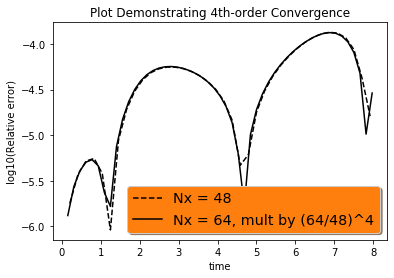

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpmath as mp
import csv

def file_reader(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=" ")
        data  = list(zip(*reader))
        # data is a tuple of strings. Tuples are immutable, and we need to perform math on
        #   the data, so here we convert tuple to lists of floats:
        data0 = []
        data1 = []
        for i in range(len(data[0])):
            data0.append(float(data[0][i]))
            data1.append(float(data[1][i]))
        return data0,data1
    
first_col48,second_col48 = file_reader(os.path.join(outdir,"out48.txt"))
first_col64,second_col64 = file_reader(os.path.join(outdir,"out64.txt"))

for i in range(len(second_col64)):
    # data64 = data48*(64/48)**4 
    # -> log10(data64) = log10(data48) + 4*log(64/48)
    second_col64[i] += 4*mp.log10(64./48.)

# https://matplotlib.org/gallery/text_labels_and_annotations/legend.html#sphx-glr-gallery-text-labels-and-annotations-legend-py        
fig, ax = plt.subplots()

plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("time")
plt.ylabel("log10(Relative error)")

ax.plot(first_col48, second_col48, 'k--', label='Nx = 48')
ax.plot(first_col64, second_col64, 'k-', label='Nx = 64, mult by (64/48)^4')
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 4: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-ScalarWave.pdf](Tutorial-Start_to_Finish-ScalarWave.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [9]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx --log-level='WARN' Tutorial-Start_to_Finish-ScalarWave.ipynb
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWave.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWave.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWave.tex
!rm -f Tut*.out Tut*.aux Tut*.log

This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
